In [ ]:
try:
    import wordcloud
    print("All modules are already installed.")
except ImportError:
    !pip install wordcloud


All modules are already installed.


In [ ]:
import pandas as pd
import numpy as np

# NLP imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.model_selection import train_test_split

# viz imports
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Provide root path to dataset
dataset_root = '/content/drive/MyDrive/UMich Milestone II Project/Final_Code_Submission/Dataset/'

## Helper Methods

In [ ]:
# Generate word clouds for each topic
def display_word_cloud(words_per_topic):
  for topic_idx, top_words in enumerate(words_per_topic):
      # wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))
      wordcloud = WordCloud(width=1000, height=600,  margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(top_words)

      plt.figure(figsize=(10, 5))
      # plt.imshow(wordcloud, interpolation='bilinear')
      plt.imshow(wordcloud)
      plt.title(f'Topic {topic_idx + 1} Word Cloud')
      plt.axis('off')
      plt.show()

# Get Top N words per topic
def get_top_words_per_topic(topic_term_matrix, feature_names, num_top_words, verbose=True):
    top_words_per_topic = []
    for topic_idx, topic in enumerate(topic_term_matrix):
        terms = ", ".join([feature_names[i] for i in topic.argsort()[: -num_top_words - 1 : -1]])
        if verbose:
            print("Topic %d:" % (topic_idx + 1))
            print(terms)
        top_words_per_topic.append(terms)
    return top_words_per_topic

# Calculate Coherence score
def calc_coherence_score(top_words_per_topic, token_reviews):
    # Tokenize top N terms perTopic
    tokenized_top_words_per_topic = [sentence.split(", ") for sentence in top_words_per_topic]

    # Creating a dictionary with the vocabulary
    word2id = Dictionary(token_reviews)

    # Coherence model
    # https://radimrehurek.com/gensim/models/coherencemodel.html
    cm = CoherenceModel(topics=tokenized_top_words_per_topic,
                        texts=token_reviews,
                        coherence='c_v',
                        dictionary=word2id)

    coherence_score_per_topic = cm.get_coherence_per_topic()
    print(f"Coherence score for Topics {coherence_score_per_topic}")
    coherence_score = cm.get_coherence()
    print(f"Coherence score for Topics {coherence_score}")
    return coherence_score

# Reviews with highest relevance to topics
def top_review_per_topic(doc_topic_matrix, no_topics):
    # print("LDA transform output:\n", lda_doc_topic_matrix)

    best_document_per_topic = np.argsort(doc_topic_matrix, axis=0)[::-1]
    for topic_index in range(0, no_topics):
        best_index = best_document_per_topic[0, topic_index]
        print(
            "Highest topic",
            topic_index + 1,
            "weight is document",
            best_index,
            ": \n \n",
            df_reviews['text'].iloc[best_index]
        )
        print("===================== \n")

In [ ]:
# TO DO: Move below code to data prep notebook
# DATA CLEANING AND PREPPING FUNCTIONS
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')
nltk.download('wordnet')

# punctuation_removal function
def punctuation_removal(tokens):
    token_lst = []
    for token in tokens:
        if token not in string.punctuation:
            token_lst.append(token)
    return token_lst

# stopword_removal function
def stopword_removal(tokens):
    token_lst = []
    for token in tokens:
        if token not in stop_words:
            token_lst.append(token)
    return token_lst

def stemm(tokens):
    token_lst = []
    for token in tokens:
        token_lst.append(PorterStemmer().stem(token))
    return token_lst

def review_clean(text):

    # lowercasing review text
    text = text.lower()
    # tokenizing review text
    tokens = word_tokenize(text)
    # use punctuation_removal function
    tokens = punctuation_removal(tokens)
    # use stopword_removal function
    tokens = stopword_removal(tokens)
    # use stemm function
    tokens = stemm(tokens)

    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Data Pre processing

In [ ]:
# Load food reviews
# df_reviews = pd.read_json(dataset_root + "philadelphia_restaurant_reviews.json", lines=True)
df_reviews = pd.read_json(dataset_root + "philadelphia_restaurant_reviews.json")


In [ ]:
# Get the restaurant with most reviews in Philadelphia
grouped_df = df_reviews.groupby('business_id').size().reset_index(name='count_of_entries')
sorted_df = grouped_df.sort_values(by='count_of_entries', ascending=False)
sorted_df.head()

,business_id,count_of_entries
5749,ytynqOUb3hjKeJfRj5Tshw,5778
2409,PP3BBaVxZLcJU54uP_wL6Q,4293
1798,IkY2ticzHEn4QFn8hQLSWg,3428
963,9PZxjhTIU7OgPIzuGi89Ew,3264
3703,ctHjyadbDQAtUFfkcAFEHw,3173


In [ ]:
df_reviews = df_reviews[df_reviews['business_id'] == 'ytynqOUb3hjKeJfRj5Tshw']
df_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
616043,kKC5pBPkUCWo6mKYFUewRw,mGnZFbk2gqLLtGW-mYo__A,ytynqOUb3hjKeJfRj5Tshw,5,0,0,0,I love this place! Doesn't take me long to get...,2016-08-25 16:30:53
616064,sFQrhTbTah0o2kU_Pi2D0Q,Tu4ATXLhy8kRTjpQCnl2pA,ytynqOUb3hjKeJfRj5Tshw,5,0,0,0,"One of my favorite places to go to in Philly, ...",2016-07-14 20:24:15
616075,kqn1uP3LRVjVDUD44ZSu1A,vRNb2IaGlsZRA_wUf3Ov8w,ytynqOUb3hjKeJfRj5Tshw,5,0,0,0,This might be a bit unfair to have a single re...,2017-04-07 22:27:22
616078,qMsTe9QznpNQk1AKbYLp-w,29K-usmZfVDeIaQ85EG54A,ytynqOUb3hjKeJfRj5Tshw,4,5,2,3,"Alright, I remember the first time I went to t...",2017-07-18 17:33:29
616108,nmMIRBNONIICe7CFHnfadQ,1jE--VcTddwXGampD23JCg,ytynqOUb3hjKeJfRj5Tshw,4,0,0,0,"It's an experience, to say the least! Not as ...",2013-08-03 20:18:22


In [ ]:
df_reviews.groupby('stars').size()

stars
1      24
2      70
3     304
4    1366
5    4014
dtype: int64

In [ ]:
# TO DO: Move below code to data prep notebook
# Tokenize and clean review text
df_reviews['clean_text'] = df_reviews['text'].apply(lambda x: review_clean(x))


# LSI (Latent Semantic Indexing)
References:


1. SIADS 543 notebook : https://www.coursera.org/learn/siads543/programming/MRNyC/assignment-3-create/lab?path=%2Fnotebooks%2Fassignments%2Fassignment3%2Fassignment3.ipynb
2. http://derekgreene.com/slides/topic-modelling-with-scikitlearn.pdf

### Extract features

In [ ]:
# Init TF-IDF vectorizer and fit the review corpus
#'''
tfidf = TfidfVectorizer(max_features = 10000,
    ngram_range = (1,2),
    min_df=20,
    max_df=0.95,
    stop_words='english')
#'''

# tfidf = TfidfVectorizer(stop_words='english',smooth_idf=True)

# Generate doc-term matrix
tfidf_reviews = tfidf.fit_transform(df_reviews['text'])
print(f" Document-Term matrix dims: {tfidf_reviews.shape}")

 Document-Term matrix dims: (5778, 1952)


In [ ]:
# List of extracted top 1000 n-gram terms
tfidf_terms = tfidf.get_feature_names_out()
print(f"# of terms in vocab {tfidf_terms.shape}")

# of terms in vocab (1952,)


### Train Model

In [ ]:
def lsi_topic_model(tfidf_reviews_in, n_topics):

    # LSI does truncated SVD on the document-term matrix of tf.idf term-weights.
    # The matrix we got back from the vectorizer is a document-term matrix, i.e. one row per document.
    # lsi = TruncatedSVD(n_components=n_topics, algorithm='randomized', n_iter=100, random_state=122)
    lsi = TruncatedSVD(n_components=n_topics, n_iter=100, random_state=122)

    # returned object is Document-Topic matrix
    doc_topic_matrix = lsi.fit_transform(tfidf_reviews_in)

    # document - topic matrix
    print(f"Document-Topic matrix dims: {doc_topic_matrix.shape}")

    # Singular values matrix
    sing_value_matrix = lsi.singular_values_
    print(f"Singular values matrix dims: {sing_value_matrix.shape}")

    # topic - term matrix
    topic_term_matrix = lsi.components_
    print(f"Topic-Term matrix dims: {topic_term_matrix.shape}")

    return doc_topic_matrix, sing_value_matrix, topic_term_matrix


In [ ]:
# Select Top N Topics
# n_topics = 7

# LSI does truncated SVD on the document-term matrix of tf.idf term-weights.
# The matrix we got back from the vectorizer is a
# document-term matrix, i.e. one row per document.
# lsi = TruncatedSVD(n_components=n_topics, n_iter=100, random_state=122)
# lsi = TruncatedSVD(n_components=n_topics, algorithm='randomized', n_iter=100, random_state=122)

# returned object is Document-Topic matrix
# %%time
# doc_topic_matrix = lsi.fit_transform(tfidf_reviews)

# document - topic matrix
# print(f" Document-Topic matrix dims: {doc_topic_matrix.shape}")

# Singular values matrix
# sing_value_matrix = lsi.singular_values_
# print(f" Singular values matrix dims: {sing_value_matrix.shape}")

# topic - term matrix
# topic_term_matrix = lsi.components_
# print(f" Topic-Term matrix dims: {topic_term_matrix.shape}")

### Fine Tune Model

In [ ]:
# scores for different # of topics
result = []

# range of numbers of topics to evaluate
num_topics_range = range(2, 16)

for n_topic in num_topics_range:

    # NMF based topic modeling
    doc_topic_matrix, sing_value_matrix, topic_term_matrix = lsi_topic_model(tfidf_reviews, n_topic)

    # Get top 10 terms for each topic
    top_terms = get_top_words_per_topic(topic_term_matrix, tfidf_terms, 7, verbose=False)
    # Calculate Coherence score
    result.append(calc_coherence_score(top_terms, df_reviews['clean_text']))

Document-Topic matrix dims: (5778, 2)
Singular values matrix dims: (2,)
Topic-Term matrix dims: (2, 1952)
Coherence score for Topics [0.561886424651519, 0.7410353292871582]
Coherence score for Topics 0.6514608769693386
Document-Topic matrix dims: (5778, 3)
Singular values matrix dims: (3,)
Topic-Term matrix dims: (3, 1952)
Coherence score for Topics [0.561886424651519, 0.7410353292871582, 0.753256947831989]
Coherence score for Topics 0.6853929005902222
Document-Topic matrix dims: (5778, 4)
Singular values matrix dims: (4,)
Topic-Term matrix dims: (4, 1952)
Coherence score for Topics [0.561886424651519, 0.7410353292871582, 0.753256947831989, 0.5777963786371115]
Coherence score for Topics 0.6584937701019445
Document-Topic matrix dims: (5778, 5)
Singular values matrix dims: (5,)
Topic-Term matrix dims: (5, 1952)
Coherence score for Topics [0.561886424651519, 0.7410353292871582, 0.753256947831989, 0.5777963786371115, 0.5949004835892177]
Coherence score for Topics 0.6457751127993991
Documen

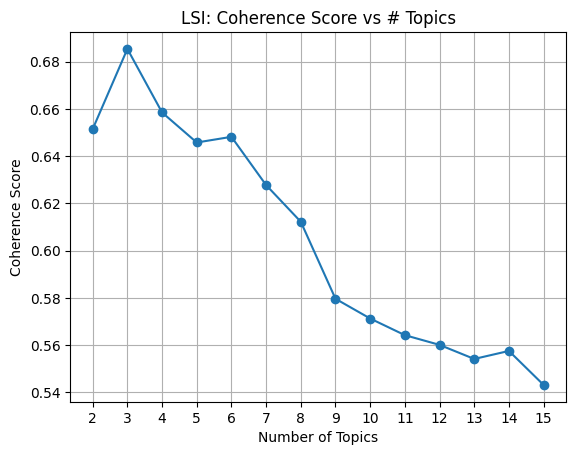

In [ ]:

# Plot the elbow plot
plt.plot(num_topics_range, result, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('LSI: Coherence Score vs # Topics')
plt.xticks(num_topics_range)
plt.grid(True)
plt.show()

### Inference

In [ ]:
# Select Top N Topics
n_topics = 3

# LSI based topic modeling
doc_topic_matrix, sing_value_matrix, topic_term_matrix = lsi_topic_model(tfidf_reviews, n_topics)

# Get top N terms for each topic
lsi_top_words_per_topic = get_top_words_per_topic(topic_term_matrix, tfidf_terms, 7)

Document-Topic matrix dims: (5778, 3)
Singular values matrix dims: (3,)
Topic-Term matrix dims: (3, 1952)
Topic 1:
place, food, market, great, terminal, reading, philly
Topic 2:
reading, terminal, reading terminal, terminal market, market, love reading, philadelphia
Topic 3:
cream, ice cream, ice, pork, sandwich, roast, roast pork


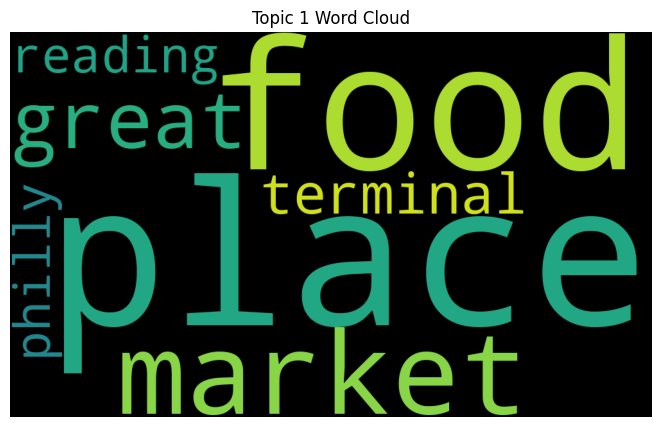

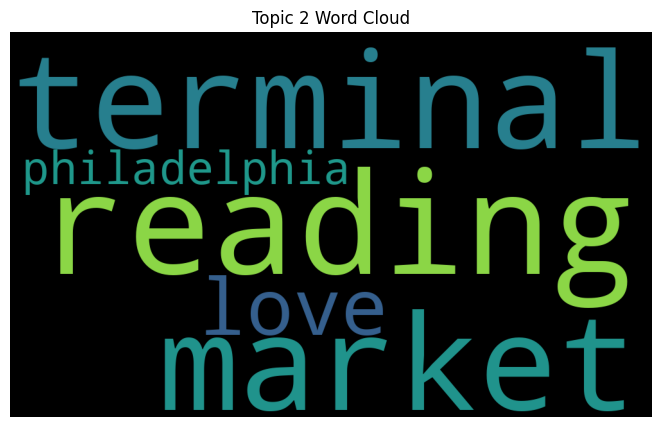

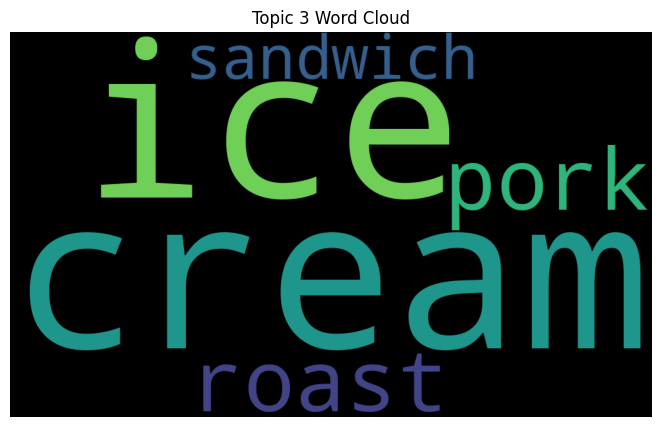

In [ ]:
# Generate word clouds for each topic
display_word_cloud(lsi_top_words_per_topic)

### Evaluation

In [ ]:
# Calculate Coherence score
calc_coherence_score(lsi_top_words_per_topic, df_reviews['clean_text'])

Coherence score for Topics [0.561886424651519, 0.7410353292871582, 0.753256947831989]
Coherence score for Topics 0.6853929005902222


0.6853929005902222

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


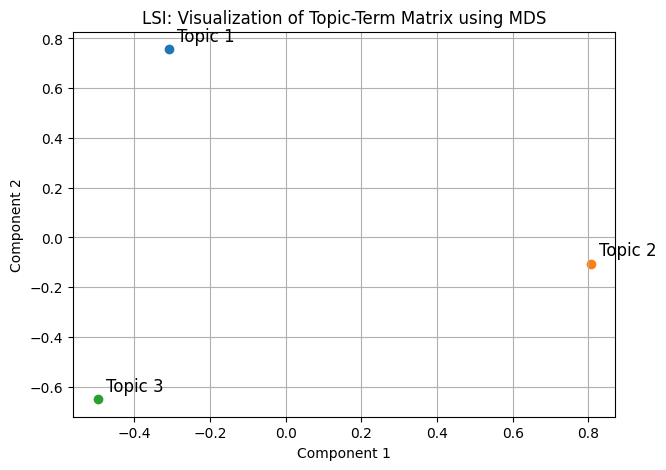

In [ ]:
# Perform dimensionality reduction using MDS
mds = MDS(n_components=2, random_state=42)

# tsne = TruncatedSVD(n_components=2, random_state=42)
# tsne = PCA(n_components=2, random_state=42)
# tsne = TSNE(n_components=2, random_state=42, perplexity=8)

mds_data = mds.fit_transform(topic_term_matrix)

num_topics = len(topic_term_matrix)
topic_labels = ['Topic ' + str(i + 1) for i in range(num_topics)]

# Visualize the data
plt.figure(figsize=(7, 5))
for i in range(len(topic_labels)):
    plt.scatter(mds_data[i, 0], mds_data[i, 1], label=topic_labels[i])

    # Annotate the scatter plot with topic labels
    plt.annotate(topic_labels[i],
                  xy=(mds_data[i, 0], mds_data[i, 1]),
                  xytext=(6, 3),
                  textcoords='offset points',
                  ha='left',
                  va='bottom',
                  fontsize=12)

plt.title('LSI: Visualization of Topic-Term Matrix using MDS')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# LDA (Latent Dirichlet Allocation)

References:

1. https://www.coursera.org/learn/siads543/ungradedLab/g17Vp/module-3-notebook/lab?path=%2Fnotebooks%2Fresources%2FMADS_Unsupervised_Learning_Module_3.ipynb
2.


### Extract Features

In [ ]:
# Use Term frequemcy (CountVectorizer) instead of TF-IDF since LDA is a probabilistic generative algo
tf_vectorizer = CountVectorizer(
    max_features=10000,  # only top 10k by freq
    lowercase=True,  # keep capitalization
    ngram_range=(1, 2),  # include 2-word phrases
    min_df=10,  # note: absolute count of doc
    max_df=0.95,  # note: % of docs
    stop_words="english",
)
# tf_vectorizer = CountVectorizer(stop_words="english")

tf_reviews = tf_vectorizer.fit_transform(df_reviews['text'])
print(f"Document-Term matrix dims: {tf_reviews.shape}")

tf_vocab = tf_vectorizer.get_feature_names_out()
print(f"# of terms in vocab: {tf_vocab.shape}")

Document-Term matrix dims: (5778, 3770)
# of terms in vocab: (3770,)


### Train

In [ ]:
# select top N topics
# n_topics = 7

# lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
# %%time
# lda.fit(tf_reviews)

# Use transform on the original document-term matrix to get the document weights per topic
# lda_doc_topic_matrix = lda.transform(tf_reviews)
# print(f"Document-Topic matrix dims: {lda_doc_topic_matrix.shape}")

# lda_topic_term_matrix = lda.components_
# print(f"Topic-Term matrix dims: {lda_topic_term_matrix.shape}")

In [ ]:
def lda_topic_model(tf_reviews, n_topics):

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)

    # Fit LDA to doc-term matrix
    lda.fit(tf_reviews)

    # Use transform on the original document-term matrix to get the document weights per topic
    lda_doc_topic_matrix = lda.transform(tf_reviews)
    print(f"Document-Topic matrix dims: {lda_doc_topic_matrix.shape}")

    lda_topic_term_matrix = lda.components_
    print(f"Topic-Term matrix dims: {lda_topic_term_matrix.shape}")

    return lda_doc_topic_matrix, lda_topic_term_matrix


### Fine Tune

In [ ]:
# scores for different # of topics
result = []

# range of numbers of topics to evaluate
num_topics_range = range(2, 16)

for n_topic in num_topics_range:

    # LDA based topic modeling
    lda_doc_topic_matrix, lda_topic_term_matrix = lda_topic_model(tf_reviews, n_topic)

    # Get top N terms for each topic
    top_terms = get_top_words_per_topic(lda_topic_term_matrix, tf_vocab, 7, verbose=False)

    # Calculate Coherence score
    result.append(calc_coherence_score(top_terms, df_reviews['clean_text']))


Document-Topic matrix dims: (5778, 2)
Topic-Term matrix dims: (2, 3770)
Coherence score for Topics [0.5560622249902984, 0.4681012517107744]
Coherence score for Topics 0.5120817383505364
Document-Topic matrix dims: (5778, 3)
Topic-Term matrix dims: (3, 3770)
Coherence score for Topics [0.501464439758377, 0.4681012517107744, 0.6281532238978774]
Coherence score for Topics 0.5325729717890096
Document-Topic matrix dims: (5778, 4)
Topic-Term matrix dims: (4, 3770)
Coherence score for Topics [0.4465287500532317, 0.4711234170736951, 0.3459523579024339, 0.6268968275232708]
Coherence score for Topics 0.4726253381381579
Document-Topic matrix dims: (5778, 5)
Topic-Term matrix dims: (5, 3770)
Coherence score for Topics [0.4465287500532317, 0.49588595584142736, 0.34595235790243384, 0.5916605965334626, 0.45849844406581575]
Coherence score for Topics 0.4677052208792743
Document-Topic matrix dims: (5778, 6)
Topic-Term matrix dims: (6, 3770)
Coherence score for Topics [0.4465287500532317, 0.507817328171

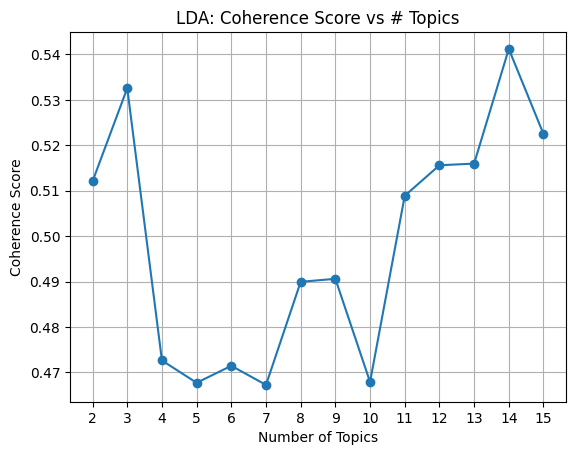

In [ ]:
# Plot the elbow plot
plt.plot(num_topics_range, result, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('LDA: Coherence Score vs # Topics')
plt.xticks(num_topics_range)
plt.grid(True)
plt.show()

### Inference

In [ ]:
# Select Top N Topics
n_topics = 14

# LDA based topic modeling
lda_doc_topic_matrix, lda_topic_term_matrix = lda_topic_model(tf_reviews, n_topics)

# Get top N terms for each topic
lda_top_words_per_topic = get_top_words_per_topic(lda_topic_term_matrix, tf_vocab, 7)


Document-Topic matrix dims: (5778, 14)
Topic-Term matrix dims: (14, 3770)
Topic 1:
food, place, eat, like, places, different, really
Topic 2:
great, place, food, great place, lunch, love, people
Topic 3:
market, place, like, food, reading, really, terminal
Topic 4:
terminal, reading, reading terminal, market, terminal market, love, food
Topic 5:
place, food, lots, eat, best, like, lunch
Topic 6:
market, food, place, reading, just, terminal, people
Topic 7:
food, philly, cheese, cookies, great, best, cookie
Topic 8:
food, fresh, terminal, reading, market, meats, reading terminal
Topic 9:
market, food, place, parking, walk, philadelphia, definitely
Topic 10:
great, fresh, produce, place, food, meat, selection
Topic 11:
pork, roast, sandwich, dinic, roast pork, cream, ice
Topic 12:
place, good, time, philly, love, just, don
Topic 13:
best, city, shopping, place, love, grocery, shop
Topic 14:
place, eating, dutch, eating place, dutch eating, cajun, eat


In [ ]:
# print("LDA transform output:\n", lda_doc_topic_matrix)

# Get Documents associated with each topic
best_document_per_topic = np.argsort(lda_doc_topic_matrix, axis=0)[::-1]
for topic_index in range(0, n_topics):
    best_index = best_document_per_topic[0, topic_index]
    print(
        "Highest topic",
        topic_index,
        "weight is document",
        best_index,
        ": \n \n",
        df_reviews['text'].iloc[best_index]
    )
    print("===================== \n")

Highest topic 0 weight is document 5686 : 
 
 This place is not how I remember it. 

You can't pause for a half of a second without someone banging into you or being irritated with your presence being in their way. I felt like I was completely surrounded by people at all times without being able to take a breath. 

There were lines everywhere. People everywhere. *Questionable* people everywhere. 

I didn't even want to eat anything because the sheer volume of people made me feel like it can't possibly be clean. 

They have produce stands, bakeries, hot and cold food stands, people selling soap, jewelry, etc. You have to really pay attention because some things seem like great deals and others seem like total ripoffs. 

We did return at the very end of the day to get some cookies and it was much calmer and tolerable at that time. If I were to return here, it would definitely be towards the end of the day when the experience is better. If you like the hustle and bustle of crowds up your 

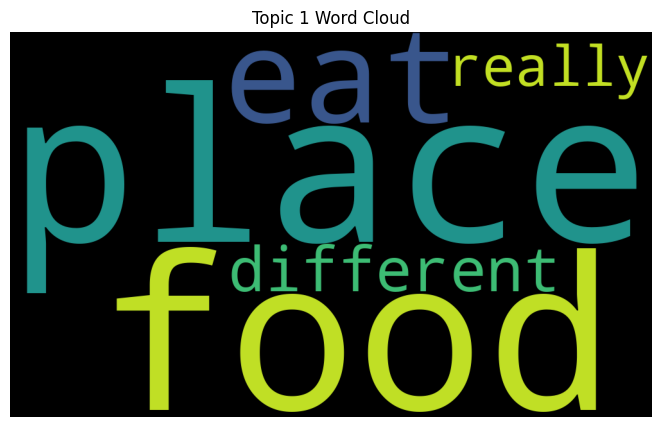

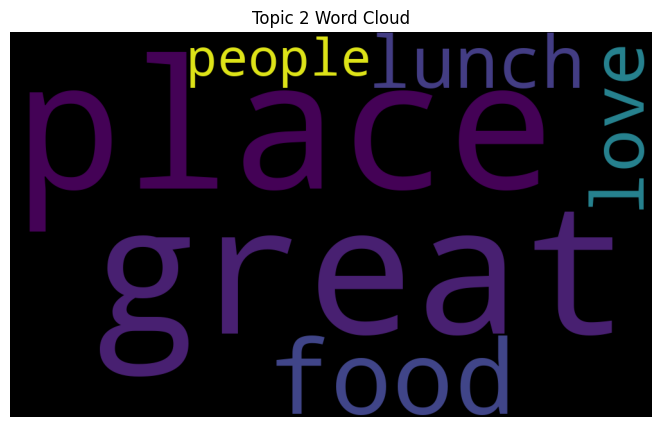

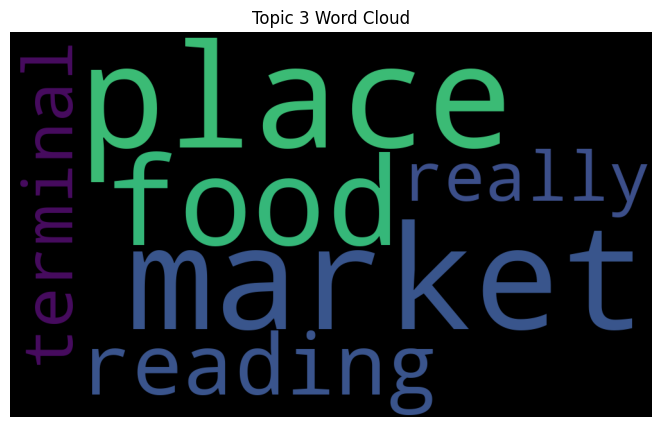

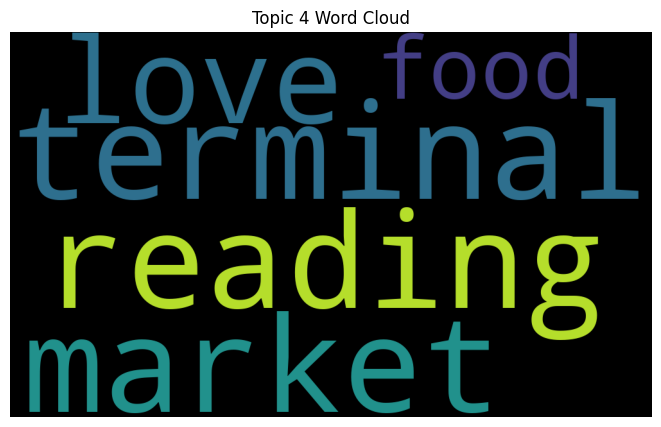

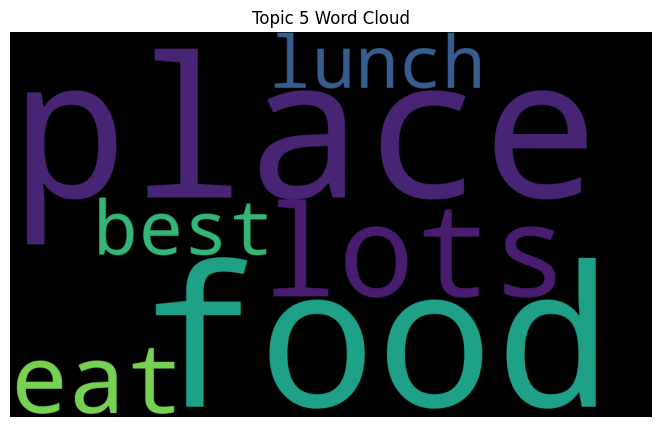

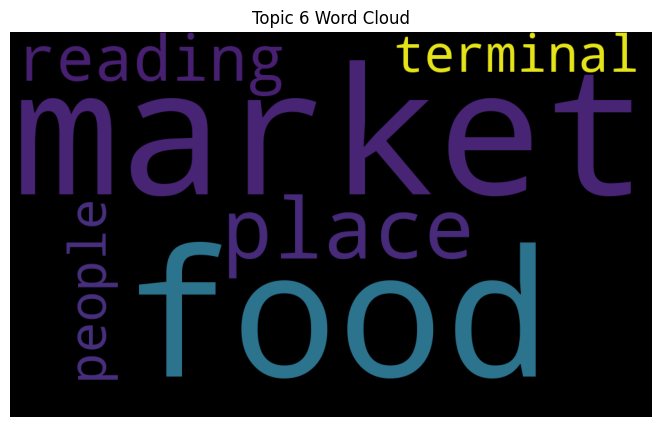

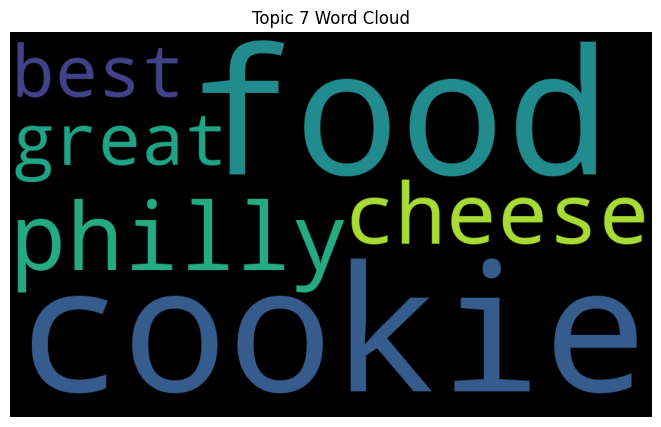

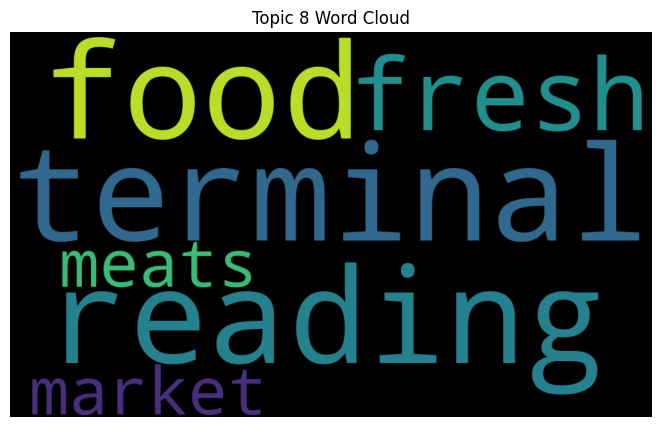

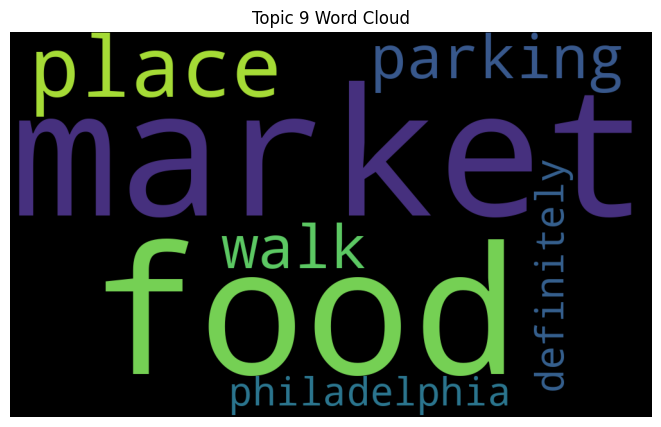

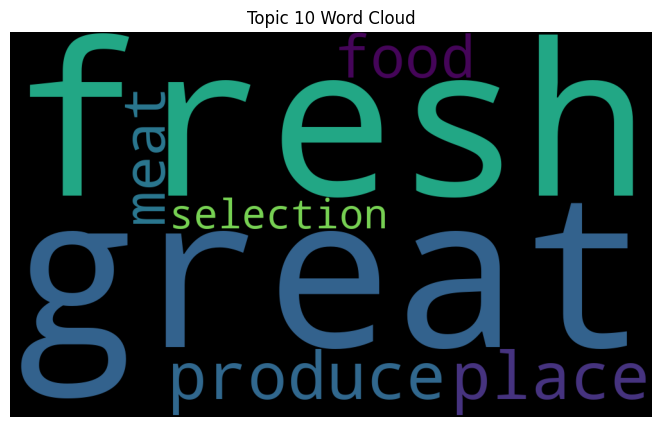

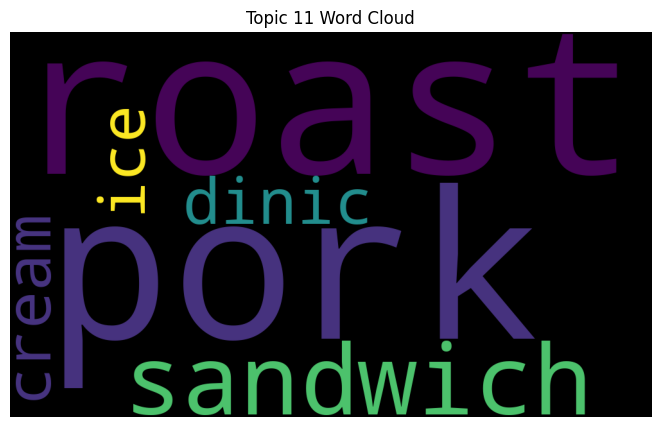

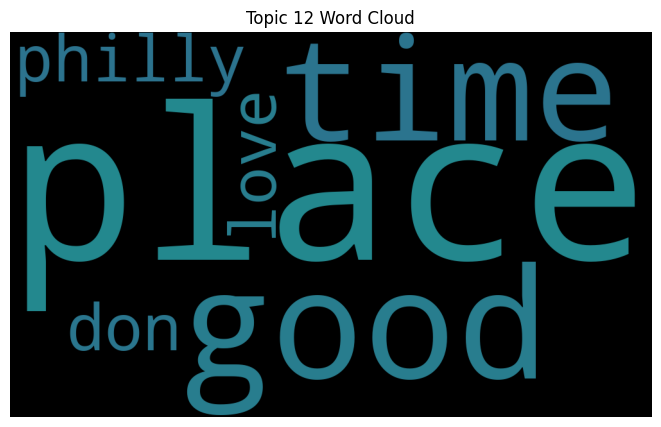

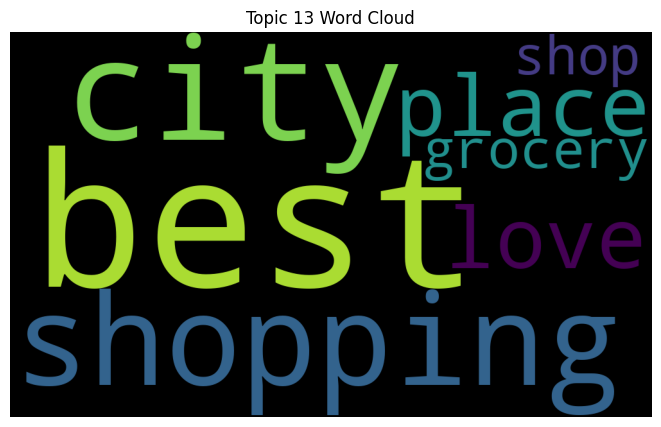

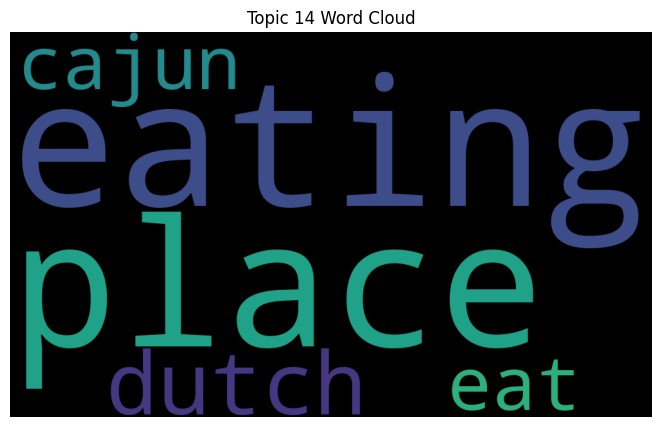

In [ ]:
# Generate word clouds for each topic
display_word_cloud(lda_top_words_per_topic)

### Evaluation

In [ ]:
# Calculate Coherence score
calc_coherence_score(lda_top_words_per_topic, df_reviews['clean_text'])

Coherence score for Topics [0.5215687360681481, 0.513465809133419, 0.5383759684720343, 0.5916605965334624, 0.42904322955081575, 0.6281532238978773, 0.3218025094971933, 0.6178354587686549, 0.5054372314965476, 0.5023505545352275, 0.7769334510440756, 0.45001062339955916, 0.561964012536527, 0.618444190940926]
Coherence score for Topics 0.541217542562462


0.541217542562462

In [ ]:
# Calculate perplexity (Lower is better)
# TO DO: Calculate perplexity on held out dataset
# perplexity_score = lda.perplexity(tf_reviews)

# Calculate approximate log-likelihood (higher is better)
# log_likelihood_score = lda.score(tf_reviews)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


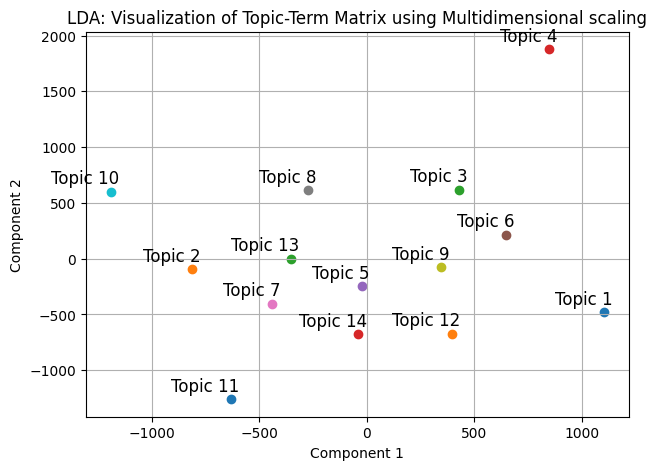

In [ ]:
# Perform dimensionality reduction using MDS
mds = MDS(n_components=2, random_state=42)

mds_data = mds.fit_transform(lda_topic_term_matrix)

num_topics = len(lda_topic_term_matrix)
topic_labels = ['Topic ' + str(i + 1) for i in range(num_topics)]

# Visualize the data
plt.figure(figsize=(7, 5))
for i in range(len(topic_labels)):
    plt.scatter(mds_data[i, 0], mds_data[i, 1], label=topic_labels[i])

    # Annotate the scatter plot with topic labels
    plt.annotate(topic_labels[i],
                  xy=(mds_data[i, 0], mds_data[i, 1]),
                  xytext=(6, 3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize=12)

plt.title('LDA: Visualization of Topic-Term Matrix using Multidimensional scaling')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# NMF (Non-negative Matrix Factorization)

References:

1. https://www.freecodecamp.org/news/advanced-topic-modeling-how-to-use-svd-nmf-in-python/
2. http://derekgreene.com/slides/topic-modelling-with-scikitlearn.pdf

### Extract Features

In [ ]:
# Init TF-IDF vectorizer and fit the review corpus
#'''
tfidf = TfidfVectorizer(
    max_features = 10000,
    ngram_range = (1,2),
    lowercase=True,
    min_df=10,
    max_df=0.95,
    stop_words='english')
#'''

# tfidf = TfidfVectorizer(stop_words='english',smooth_idf=True)

# Generate doc-term matrix
nmf_tfidf_reviews = tfidf.fit_transform(df_reviews['text'])
print(f" Document-Term matrix dims: {nmf_tfidf_reviews.shape}")

 Document-Term matrix dims: (5778, 3770)


In [ ]:
# List of extracted top 1000 n-gram terms
nmf_tfidf_terms = tfidf.get_feature_names_out()
print(f"# of terms in vocab {nmf_tfidf_terms.shape}")

# of terms in vocab (3770,)


### Train

In [ ]:
# Select Top N Topics
# n_topics = 7

# use SVD to init to get reliable results (instead of different results every time NMF is applied to same data).
# NMF_model = NMF(n_components=n_topics, random_state=42, init="nndsvd", max_iter=10000)

# %%time
# W = NMF_model.fit_transform(nmf_tfidf_reviews)
# H = NMF_model.components_

# Doc - topic matrix
# print(f" Document-Topic matrix dims: {W.shape}")

# topic - term matrix
# print(f" Topic-Term matrix dims: {H.shape}")

In [ ]:
def lsi_topic_model(tfidf_reviews_in, n_topics):
    # use SVD to init to get reliable results (instead of different results every time NMF is applied to same data).
    NMF_model = NMF(n_components=n_topics, random_state=42, init="nndsvd", max_iter=10000)

    # Fit NMF doc-term matrix
    W = NMF_model.fit_transform(tfidf_reviews_in)
    H = NMF_model.components_

    # Doc - topic matrix
    print(f"Document-Topic matrix dims: {W.shape}")

    # Topic - term matrix
    print(f"Topic-Term matrix dims: {H.shape}")

    return W, H


### Fine Tune Model

In [ ]:
# scores for different # of topics
result = []

# range of numbers of topics to evaluate
num_topics_range = range(2, 16)

for n_topic in num_topics_range:

    # NMF based topic modeling
    doc_topic_matrix, topic_term_matrix = lsi_topic_model(nmf_tfidf_reviews, n_topic)

    # Get top N terms for each topic
    top_terms = get_top_words_per_topic(topic_term_matrix, nmf_tfidf_terms, 7, verbose=False)

    # Calculate Coherence score
    result.append(calc_coherence_score(top_terms, df_reviews['clean_text']))

Document-Topic matrix dims: (5778, 2)
Topic-Term matrix dims: (2, 3770)
Coherence score for Topics [0.46232859340590077, 0.7040500810402354]
Coherence score for Topics 0.5831893372230681
Document-Topic matrix dims: (5778, 3)
Topic-Term matrix dims: (3, 3770)
Coherence score for Topics [0.46072920530431644, 0.7040500810402354, 0.776933451044076]
Coherence score for Topics 0.6472375791295426
Document-Topic matrix dims: (5778, 4)
Topic-Term matrix dims: (4, 3770)
Coherence score for Topics [0.44066855104855196, 0.7040500810402354, 0.776933451044076, 0.5078173281717423]
Coherence score for Topics 0.6073673528261514
Document-Topic matrix dims: (5778, 5)
Topic-Term matrix dims: (5, 3770)
Coherence score for Topics [0.44066855104855196, 0.7410353292871582, 0.776933451044076, 0.6407320282133923, 0.6340757349484872]
Coherence score for Topics 0.6466890189083332
Document-Topic matrix dims: (5778, 6)
Topic-Term matrix dims: (6, 3770)
Coherence score for Topics [0.44066855104855196, 0.741035329287

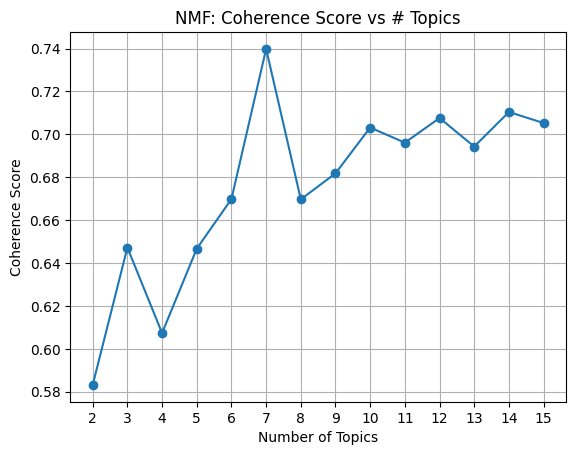

In [ ]:

# Plot the elbow plot
plt.plot(num_topics_range, result, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('NMF: Coherence Score vs # Topics')
plt.xticks(num_topics_range)
plt.grid(True)
plt.show()

### Inference

In [ ]:
# Select Top N Topics
n_topics = 7

# NMF based topic modeling
doc_topic_matrix, topic_term_matrix = lsi_topic_model(nmf_tfidf_reviews, n_topics)

# Get top N terms for each topic
nmf_top_words_per_topic = get_top_words_per_topic(topic_term_matrix, nmf_tfidf_terms, 7)

Document-Topic matrix dims: (5778, 7)
Topic-Term matrix dims: (7, 3770)
Topic 1:
place, food, eat, philly, time, good, like
Topic 2:
terminal, reading, reading terminal, market, terminal market, love reading, philadelphia
Topic 3:
pork, sandwich, roast, roast pork, dinic, pork sandwich, dinic roast
Topic 4:
fresh, produce, meats, best, fresh produce, meat, seafood
Topic 5:
great, great place, place, food, great food, food great, place great
Topic 6:
love, love place, love love, place, love reading, absolutely love, absolutely
Topic 7:
cream, ice, ice cream, bassett, bassett ice, bassetts, bassetts ice


In [ ]:
# get most relevant reviews to given topics
top_review_per_topic(doc_topic_matrix, n_topics)

Highest topic 1 weight is document 978 : 
 
 Calling this a "grocery" is a bit misleading.  They do sell groceries, in that there are some stands selling fresh produce or meat - I seem to recall that having a few of these to serve local buyers who live nearby is a condition of the market continuing to operate.  But mostly, the Reading Terminal Market is a big noisy crowded bunch of prepared food stands, with a couple sit-down restaurants thrown in. 

The food served here varies from Chinese to cheesesteaks to seafood to diner fare, and it all ranges from good to very good (though I think Philly has several better places to get a cheesesteak if you're spending more than a day or two in town). I especially like the pizza sold by the large Italian stand,  and on certain days of the week there is an Amish shop inside that serves good breakfast.  There's also a historic ice cream shop that has been selling ice cream longer than any place else in USA and has sold to Presidents, etc.  The mar

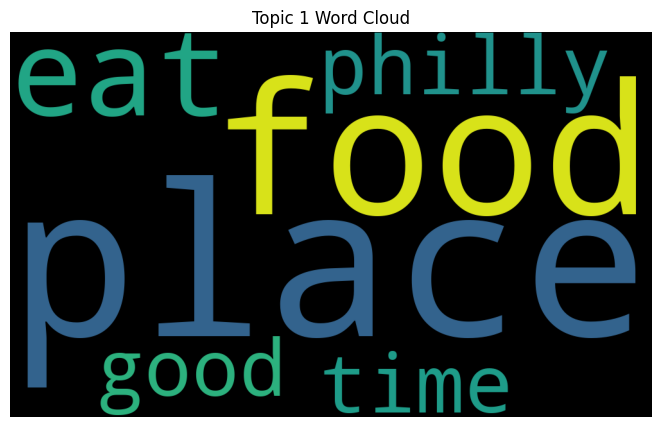

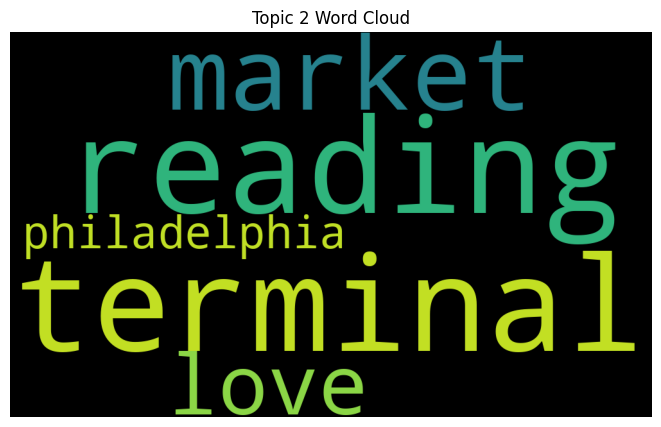

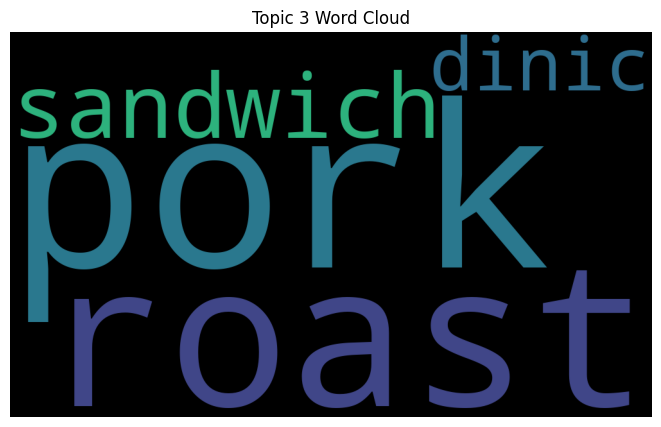

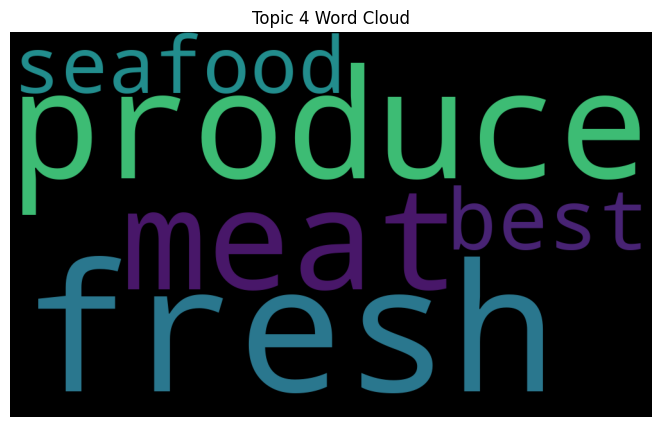

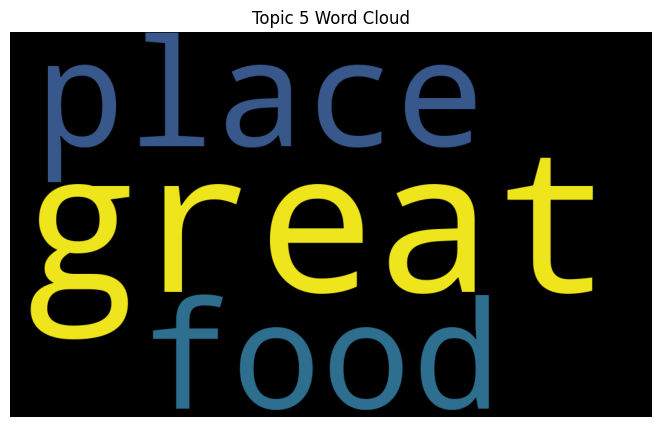

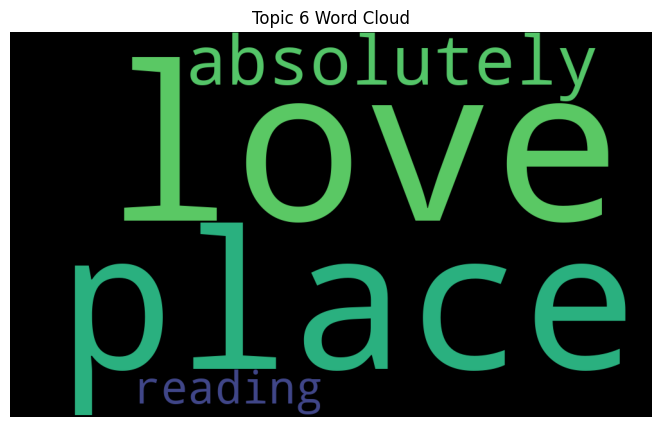

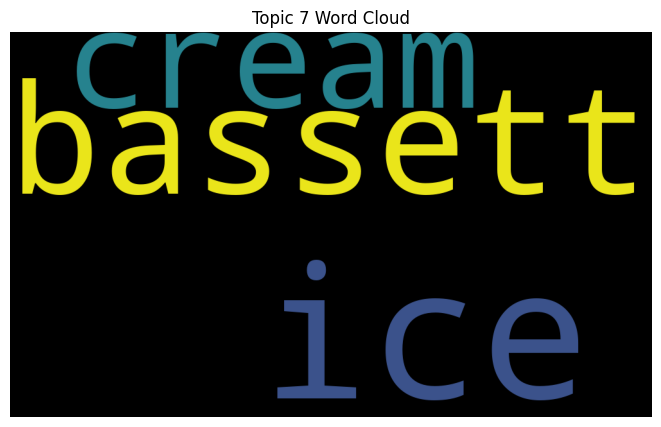

In [ ]:
# Generate word clouds for each topic
display_word_cloud(nmf_top_words_per_topic)

**Topic interpretations:**

Topic 1 and 2 suggest that the restaurant is located in a bustling area near a terminal.

Topic 3 indicates that the restaurant is renowned for its pork picnic roast sandwiches.

Topic 4 suggests that the restaurant is famous for its fresh selection of meat and seafood produce.

Topics 5 and 6 imply that it is a fantastic place with numerous positive reviews.

Topic 7 suggests that the restaurant offers excellent desserts and ice cream.


### Evaluation

In [ ]:
# Calculate Coherence score
calc_coherence_score(nmf_top_words_per_topic, df_reviews['clean_text'])

Coherence score for Topics [0.44066855104855196, 0.7410353292871582, 0.9410970425780679, 0.6752486938331317, 0.6340757349484872, 0.7747749438433437, 0.9719521099509517]
Coherence score for Topics 0.7398360579270988


0.7398360579270988

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


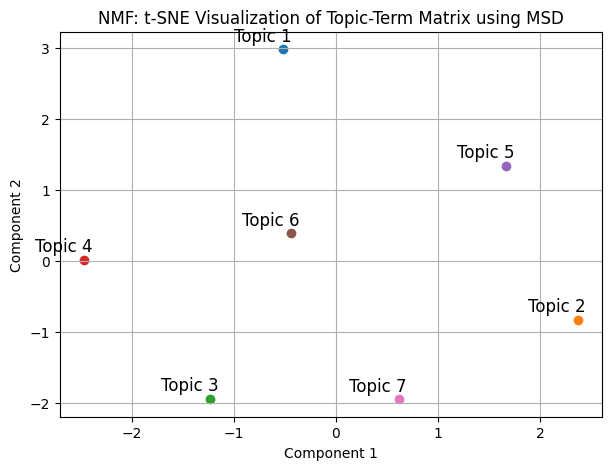

In [ ]:
# Perform dimensionality reduction using MDS
mds = MDS(n_components=2, random_state=42)
mds_data = mds.fit_transform(topic_term_matrix)

num_topics = len(topic_term_matrix)
topic_labels = ['Topic ' + str(i + 1) for i in range(num_topics)]

# Visualize the data
plt.figure(figsize=(7, 5))
for i in range(len(topic_labels)):
    plt.scatter(mds_data[i, 0], mds_data[i, 1], label=topic_labels[i])

    # Annotate the scatter plot with topic labels
    plt.annotate(topic_labels[i],
                  xy=(mds_data[i, 0], mds_data[i, 1]),
                  xytext=(6, 3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize=12)

plt.title('NMF: Visualization of Topic-Term Matrix using MSD')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()